In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-03-02_10-15-22'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp

In [6]:
ensure_dir(filename_prefix)

### Get camera information

In [7]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)
- [Kinect SDK](https://microsoft.github.io/Azure-Kinect-Sensor-SDK/master/structk4a__device__configuration__t_a8208974f05d89fc1362c6a0900bdef4d.html#a8208974f05d89fc1362c6a0900bdef4d)

In [8]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [9]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": True,
            "save_color": True,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [10]:
_dtype = np.uint16

In [11]:
def process_depth(depth):
    #return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    return depth.astype(_dtype)
def process_ir(ir):
    #ir = np.clip(ir + 100, 160, 5500)
    #return ((np.log(ir) - 5) * 70).astype(_dtype)
    return ir.astype(_dtype)

### Recording parameters

In [12]:
ir_depth_write_frames_kwargs={
        "codec": "ffv1", #"ffv1",
        "crf": 14,
        "threads": 8,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [13]:
color_write_frames_kwargs={
        "codec": "ffv1", #"h264",
        "crf": 22,
        "threads": 8,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [14]:
recording_duration = 20

### Run recording

In [15]:
start_recording(
    filename_prefix,
    recording_duration,
    devices=devices,
    depth_function = process_depth,
    ir_function = process_ir,
    ir_depth_dtype = _dtype,
    ir_depth_write_frames_kwargs=ir_depth_write_frames_kwargs,
    color_write_frames_kwargs=color_write_frames_kwargs
)

master (frames written):   0%|          | 0/600 [00:00<?, ?it/s]

Recording (s):   0%|          | 0/20 [00:00<?, ?it/s]

capture_from_azure initialized: master 
 Finished recording: 2022-03-02 10:15:49.928263
Framerate (master):30.0461
 Finished writing (master): 2022-03-02 10:15:55.416292


In [38]:
# check if anything is still writing
for device in devices:
    print("device {}:".format(device), np.load(filename_prefix/device/"is_writing.txt.npy")[0])

device master: False


### Read and show file

In [16]:
raise ValueError('Wait until start_recording finishes')

ValueError: Wait until start_recording finishes

In [17]:
print('\n'.join([i.as_posix() for i in list((filename_prefix/'master').iterdir())]))

/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/color.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/ir.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/calibration.json
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/system_timestamps.npy
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/depth.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/ir_timestamps.npy
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/depth_timestamps.npy
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/is_writing.txt.npy
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-03-02_10-15-22/master/color_timestamps.npy


In [18]:
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

In [19]:
len(system_timestamps)

596

In [20]:
len(system_timestamps) /((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

30.04614063111508

In [21]:
((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

19.836158238000003

In [22]:
depth_timestamps = np.load(filename_prefix / 'master' / 'depth_timestamps.npy')
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

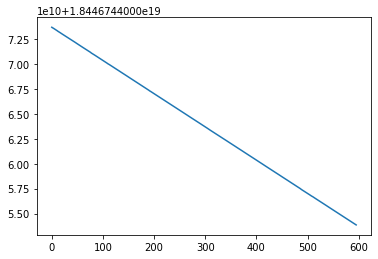

In [23]:
plt.plot((system_timestamps[0] - system_timestamps)- depth_timestamps)

In [24]:
file_loc = filename_prefix / 'master' /  "depth.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

596.0 (576, 640, 3)


In [25]:
nbit = 16
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) * 1e-9 * recording_duration/ 60*60
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 1257 MB
actual_size: 24 MB
size per hour: 0.5 GB


In [26]:
# get frame at number
vidcap.set(1, 140)
success,image = vidcap.read()

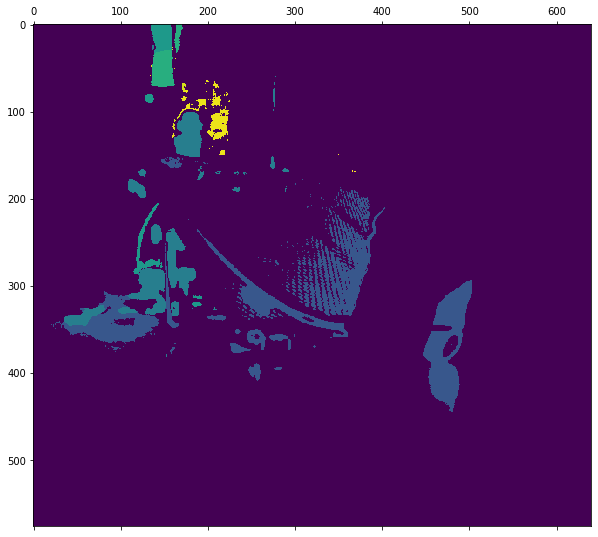

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.log(1+image)[:,:,0])

In [28]:
file_loc = filename_prefix / 'master' /  "color.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

596.0 (720, 1280, 3)


In [29]:
nbit = 8
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) * 1e-9 * recording_duration/ 60*60
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 1571 MB
actual_size: 339 MB
size per hour: 6.8 GB


In [30]:
success,image = vidcap.read()
# get frame at number
vidcap.set(1, 50)
success,image = vidcap.read()

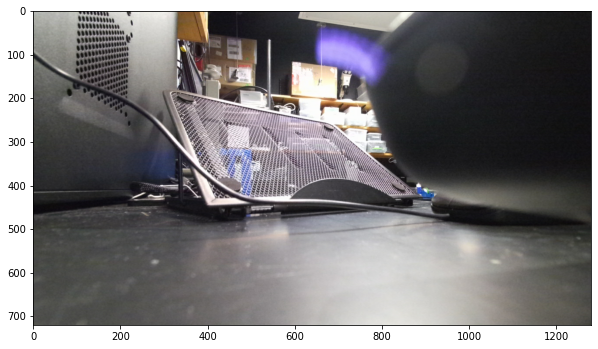

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)